This notebook is a practical guide to interpreting data from an A/B test as it comes along.

I've decided to this post as I observed that my colleagues used rules of thumb, but hadn't really had the chance to consider a logical approach that deeply understand. While most people seem to know what to do once an experiment is finished, I observed a lot of confusion to determine when to stop the experiment and what to do with data in the first few hours or days after an A/B test is turned on.

What metrics to use isn't always clear. In the case of CRM campaigns, I introduce the very simple concept of revenue per campaign recipient or website visitor = revenue per customer * primary conversion rate (e.g. click through rate), which lead to very skewed distributions. When ads need to be paid for, substract to this revenue the cost (by impression or recipient depending on your cost structure).

**This notebook is the second part of a larger series on A/B testing mathematics:**
1. A/B test sample size: statistical significance and power analysis (derivation for strong fundations - frequentist)
    - https://rugg2.github.io/AB%20testing%20-%20a%20simple%20explanation%20of%20what%20power%20analysis%20does.html
    

2. A/B testing: communicating uncertainty  and modelling prior knowledge (bootstrap and bayesian probabilities)
    - (this post)
    
    
3. A/B testing: explore vs exploit - online learning algorithms, e.g. epsilon gready & Bayesian
    - (coming soon)

**Outline of this notebook:**
- dataset: generate data inspired from real A/B tests on conversion rates and revenue KPIs
- examin early data:
    - estimate how long the experiment should run
    - communicate to curious stakeholders early results and their uncertainty
- modelling prior knowledge with Bayesian probabilities
    - what we are trying to achieve, and the concept of conjugate prior
    - conversion rate: Binomial processes (likelihood) and Beta prior and posterior
    - revenue: normal and log normal processes (likelihood) and normal-inverse gamma distribution prior and posterior

In [1]:
# standard data manipulation and visualization packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# statistical packages
#from numpy.random import beta as beta_dist
from scipy.stats import beta
from scipy.special import factorial
from scipy.stats import binom
from numpy import mean, concatenate, zeros
from numpy import exp, log, mean
from numpy.random import lognormal

from sklearn.utils import resample

# The dataset (A/B test in progress)

**generating the data**
For confidentiality reasons I will not use a real business dataset, but generate realistic data. In a real life situation you'd be importing data at this point (e.g. from a .csv file, in SQL, connecting to an API, AWS S3, etc). In real life one wouldn't know the true parameters shown in the code below.

The data I'm generating corresponds to the type of data that would come after a few days of A/B testing. I chose this case because I found most blog posts on the topic talk about analysing a complete dataset, but not how a first test is actually run.

When a new feature is tested for the first time, it often needs to be tested for a least a week, to account for variation in behaviors through different days of the week. So the experiment can be launched in practice without knowing exactly how long it will need to run for. If there is comparable historical data, a preliminary power analysis can set stakeholders' expectations (see <a href='https://rugg2.github.io/AB%20testing%20-%20a%20simple%20explanation%20of%20what%20power%20analysis%20does.html'> first post about power analysis mathematics</a>), but I find there is nothing like a couple of days of data to calculate the actual variance.

In [2]:
# typical online behaviors yield to the following case:
# - people click on advertisement / marketing campaign about 1-5% of cases
# - of the people that click, most people don't spend much money / don't use the service for very long, 
# but some do spend a lot. Overall the data sets often look pretty lognormal

# for people clicking clicking on an advertisement, model purchase / on app behavior with random log-normal data
A_log_norm_data = lognormal(mean=4.2, sigma=1.05, size=500)
B_log_norm_data = lognormal(mean=4.0, sigma=0.9, size=600)

print('campaign clicker mean: ', np.mean(A_log_norm_data), np.mean(B_log_norm_data))
print('campaign clicker median: ', np.median(A_log_norm_data), np.median(B_log_norm_data))

# model primary conversion by appending many many zeros: 500 / 10500 models ~ 5% click through rate
A_data = concatenate([A_log_norm_data,zeros((10000))])
B_data = concatenate([B_log_norm_data,zeros((10000))])

print('campaign receiver mean: ', np.mean(A_data), np.mean(B_data))
print('campaign receiver median: ', np.median(A_data), np.median(B_data))

campaign clicker mean:  116.98498186371435 88.54274813157889
campaign clicker median:  65.37107152515934 57.34879016232088
campaign receiver mean:  5.570713422081636 5.01185366782522
campaign receiver median:  0.0 0.0


In [3]:
df = pd.concat([pd.DataFrame({'group':'A', 'revenue_per_customer':A_data}),pd.DataFrame({'group':'B', 'revenue_per_customer':B_data})])
df['clicked'] = df['revenue_per_customer'].apply(lambda x: True if x>0 else False)

**exploring the data - assuming we don't know the true parameters**

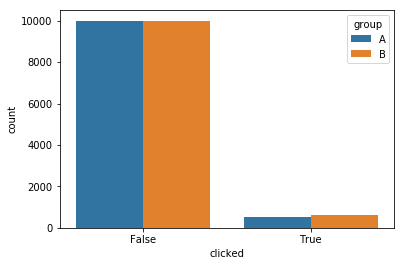

In [4]:
plt.figure()
sns.countplot(data=df, x='clicked', hue='group')

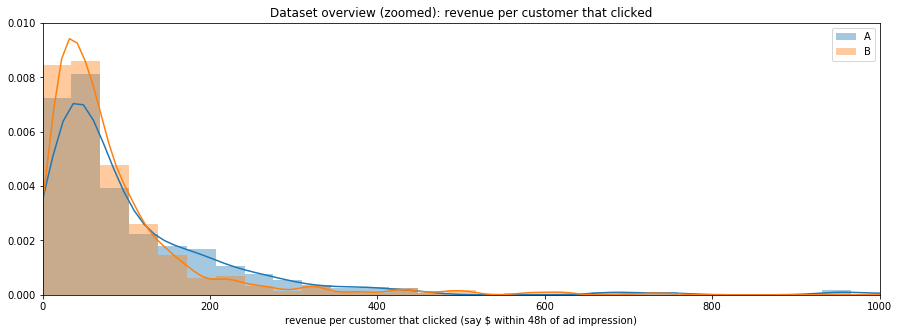

In [5]:
plt.figure(figsize=(15,5))
sns.distplot(A_log_norm_data, bins=np.linspace(0,1000,30), label='A')
sns.distplot(B_log_norm_data, bins=np.linspace(0,1000,30), label='B')
plt.xlim(0,1000)
plt.ylim(0,0.01)
plt.title('Dataset overview (zoomed): revenue per customer that clicked')
plt.xlabel('revenue per customer that clicked (say $ within 48h of ad impression)')
plt.legend()
plt.show()

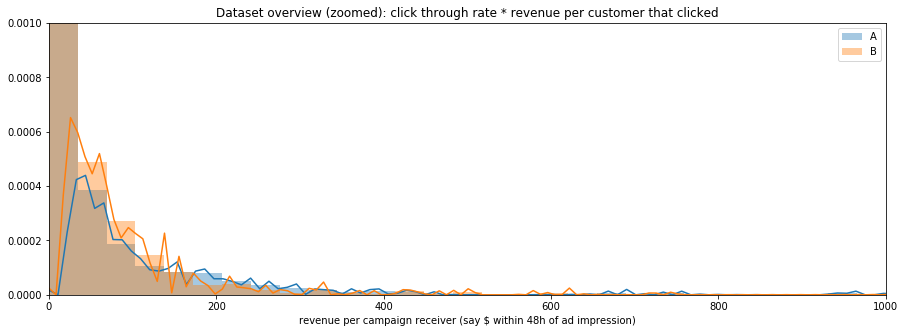

In [6]:
plt.figure(figsize=(15,5))
sns.distplot(A_data, bins=np.linspace(0,1000,30), label='A')
sns.distplot(B_data, bins=np.linspace(0,1000,30), label='B')
plt.xlim(0,1000)
plt.ylim(0,0.001)
plt.title('Dataset overview (zoomed): click through rate * revenue per customer that clicked')
plt.xlabel('revenue per campaign receiver (say $ within 48h of ad impression)')
plt.legend()
plt.show()

# Examin early data - estimate completion date and communicate uncertainty on early results


**estimate completion date**

The first question is the choice of the metric upon which success will be called. Most likely, if one pays per impression, we should try to pay for the revenue per ad impression, and if one pays per ad click one should try to optimize revenue per click.

Let's assume here that we're running our own ads on our own website. What we want to optimize is the combination of the click through rate and the revenue per click (first case). The breakdown is useful to understand the causality and diagnose how to improve the product, but they aren't the deciding KPIs.

In [7]:
# very simple look at basic statistics
summary = df.groupby('group')['revenue_per_customer'].agg(['mean', 'std'])
summary

,mean,std
group,,
A,5.570713,42.322377
B,5.011854,32.702966


In [8]:
# power calculation leveraging part one of these blog posts,
# assuming the central limit theorem will ultimately kick in
# https://rugg2.github.io/AB%20testing%20-%20a%20simple%20explanation%20of%20what%20power%20analysis%20does.html
print("Sample size estimation, given data and with the aim to detect revenue improvements or worsening of $1 per visitor or more")
print("We're ready to have 20% false negative (80% power) and 5% false positive (95% significance)")
print('n user ≥ 15.7(σ/Δ)^2 (formula derived in part one)')
Delta = 1
n_sample = 15.7 * (summary['std']**2).sum() / Delta**2
print('n users >= ',n_sample)
print()
print('This is ', n_sample / len(A_data), ' times the number of visitors to date')

Sample size estimation, given data and with the aim to detect revenue improvements or worsening of $1 per visitor or more
We're ready to have 20% false negative (80% power) and 5% false positive (95% significance)
n user ≥ 15.7(σ/Δ)^2 (formula derived in part one)
n users >=  44912.48040319851

This is  4.277379086018906  times the number of visitors to date


This generic analysis predicts that we'll probably be ready to stop the experiment in about 16 times the test period to date. So if the test has been running for 24h, if visitors keep on behaving the same way, there should be conclusive results by the end of the week (3-4 days for power and significance, and wait until the end of the week to capture behavioral changes through the week)

**communicate early results' uncertainty to pressing business stakeholders**

We'll use bootstrapping to estimate the uncertainty of the average revenue per user. Bootstrapping is a resampling method that allows error estimation

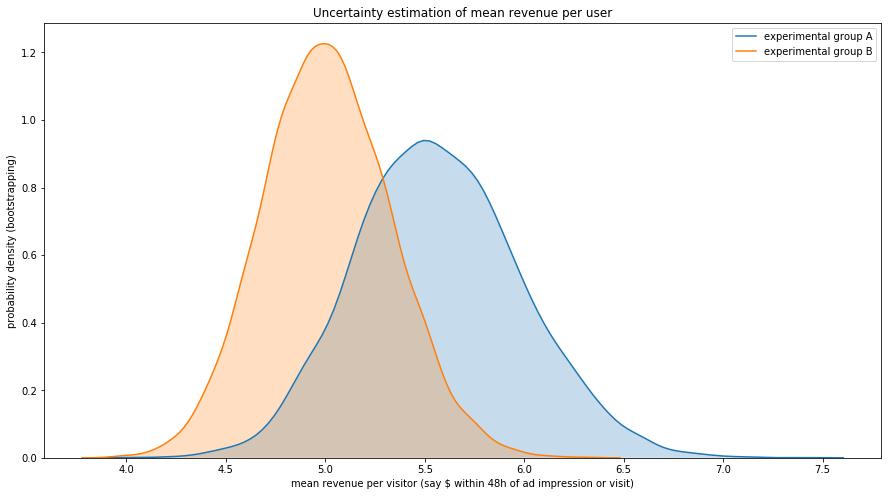

In [9]:
# estimate mean estimation uncertainty using bootstrap

A_mean_bootstrap = []
B_mean_bootstrap = []

for i in range(10000):
    A_mean_bootstrap.append(np.mean(resample(A_data, replace=True)))
    B_mean_bootstrap.append(np.mean(resample(B_data, replace=True)))

plt.figure(figsize=(15,8))
sns.distplot(A_mean_bootstrap, label='experimental group A', hist=False, kde_kws={"shade": True})
sns.distplot(B_mean_bootstrap, label='experimental group B', hist=False, kde_kws={"shade": True})
plt.xlabel('mean revenue per visitor (say $ within 48h of ad impression or visit)')
plt.ylabel('probability density (bootstrapping)')
plt.title('Uncertainty estimation of mean revenue per user')
plt.legend()

# Capture prior knowledge

A typical business situation is to be showing the results above to a marketing manager, and he comes back to you saying that he's tested ad A about 5 times before and he reminds it performing better. Ad B on the other hand is new. How to capture relevant past experiences in a quantitative way?

One way to do this are bayesian statistics. There are a lot of resources about this topic. In a nutshell, two mathematical schools look at the same problems from two different perspectives
- **frequentists $P(X | \theta)$**: estimate of the probability of the data given some parameters ('maximum likelihood')
    - this includes statistical tests like the power and statistical significance calculations we're run earlier
- **bayesian $P(\theta | X)$**: estimate the probability of the parameters given the data
    - it also happens that prior information about the parameters $\theta$ can be taken into account
    
A basic but essential part of Bayesian theory is Bayes' theorem:
$$ P(\theta|X) = \frac{P(X | \theta) \, P(\theta)}{P(X)} $$

Where:
- $P(\theta)$ is the prior
    - this represents the information about which ad is the best based on judgment or past experiments
- $P(X|\theta)$ is the likelihood
    - this represents how the data is generated, assuming the data gets generated following a chosen distribution, and with the chosen parameters $\theta$
- $P(\theta | X)$ is the posterior
- $P(X)$ is a constant 
    - this is a constant with regard to $\theta$. It also represents that the data to date is fixed. This means the denominator does not need to be considered when one tries to find the set of parameters $\theta$ that best represents the data.
    

**Structure of this section**
- what we are trying to achieve, and the concept of conjugate prior
- conversion rate: Bernoulli processes (likelihood) and Beta prior and posterior
- revenue: normal and log normal processes (likelihood) and normal-inverse gamma distribution prior and posterior

**What we are trying to achieve, and the concept of conjugate prior**
In Bayesian statistics, given the data X (e.g. each row being how much each visitor spends on our website) and prior knowledge $P(\theta)$ (e.g. previous campaigns with the same ads), one tries to fit a model to the data and estimate key statistics $P(\theta | X)$ (e.g. what's the probability that the revenue per user is \$4, \$4.5, \$5 etc). 

To do this, one tries to model the data generation process, based on knowledge of the system (e.g. differential equation in physics, or based on a logical analysis of a process e.g. flipping a coin), or based on empirical data (use a model that seems to fit the data). 

The general way to calculate the posterior $P(\theta|X)$ is to use numerical methods, typically Markov chain Monte Carlo (MCMC). In some occasions, a closed-form analytical solution exists. In particular, when the posterior and prior belond to the same functional familly, they are called conjugates. There is a really useful wikipedia article on this that I use all the times: https://en.wikipedia.org/wiki/Conjugate_prior.

Because conjuguate priors can be very convenient, data scientists tend to follow this workflow:
- identify what classic distribution can reasonably represent the likelihood $P(X|\theta)$. If none, use numerical methods
- if a classic distribution can model the likelihood, choose the prior's distribution so it is conjugate (e.g. using wikipedia's article). The conjugate prior should be able to represent a priori knowledge in a reasonable manner. If that's not the case, use numerical methods.
- calculate the posterior

Note that the Bayesian way of thinking is useful even in the absence of prior evidence. Indeed, considering parameters (such as mean revenue) as random variables with a probability distribution that gets refined as more data comes in is useful. Using a neutral prior becomes then very comparable to the bootstrapping method we explored in the previous section.

# Capturing prior knowledge - conversion rates

Conversion rates can be something like click through rates, or the fraction of visitors becoming customers. In our data set, conversion rates are as shown below:

In [10]:
print('Visitors seeing ad A that bought: ',(A_data>0).sum(), ', and visitors that did not buy: ', (A_data==0).sum(), ', so click-through rate: ' , round((A_data>0).sum() / len(A_data),3))
print('Visitors seeing ad B that bought: ',(B_data>0).sum(), ', and visitors that did not buy: ', (B_data==0).sum(), ', so click-through rate: ' , round((B_data>0).sum() / len(B_data),3))

Visitors seeing ad A that bought:  500 , and visitors that did not buy:  10000 , so click-through rate:  0.048
Visitors seeing ad B that bought:  600 , and visitors that did not buy:  10000 , so click-through rate:  0.057


Converting from visitor to buyer can be modelled as a Bernoulli process with a probability $q$ that is probably around 5%, but whose precise value is unknown. When several samples are added up e.g. to form monthly revenue, this becomes a Binomial distribution.

Once one has decided that the likelihood can be modelled with a binomial distribution, one can directly jump to the section on the prior and posterior. However, for those unfamiliar with the binomial distribution, I'll give some examples below.

**(1) Modelling the Likelihood** To model this, we call $b_1$ customers that bought, and $v_1$ the total number of visitors, then we can model and predict such probability that out of $v$ visitors $b$ will buy:
$$Likelihood: P(b, v \,| \,q) = {v \choose b}q^{b}(1-q)^{v-b} $$

*Note for calculation purposes - this is a small parenthesis in the main story*. The binomial coefficients is a special case of the Beta function (which isn't the same as the beta distribution to make things more confusing). The Beta function can be expressed with the Gamma function $\Gamma$, which is a generalisation of factorials, such that ${v \choose b} = \frac{1}{(v+1) B(v-b+1, b+1)} = \frac{\Gamma(b+1) \Gamma(v-b+1)}{(v+1) \Gamma(v+2)}$. This property gives a good sense for what the beta function is, basically some sort of generalised inverse of a binomial coefficient.

Implementation and examples below:

In [11]:
def likelihood_nonscalable(q, v, b):
    """
    likelihood function for a binomial distribution

    v: [int] the number of visitors
    b: [int] the number of visitors that bought
    q: [float] the proposed click through rate
    
    Note that this function will not scale well with large numbers, as the factorial function grows very fast.
    We actually won't need to use this function in practice to calculate the posterior, but it is useful to get an intuitive understanding.
    """
    return (factorial(v) / (factorial(b) * factorial(v - b)) * (q ** b) * ((1 - q) ** (v - b)))

def likelihood(q, v, b):
    """
    likelihood function for a binomial distribution

    v: [int] the number of visitors
    b: [int] the number of visitors that bought
    q: [float] the proposed click through rate
    """
    
    return binom.pmf(b, v, q, loc=0)

# if q == 0.04, and we want to know the probability to have exactly b=5 visitors that buy out of v=100:
print('if q==0.04:')
print((factorial(100) / (factorial(5) * factorial(100 - 5))) * (0.04 ** 5) * ((1 - 0.04) ** (100 - 5)))
print(likelihood_nonscalable(0.04, 100, 5))
print(likelihood(0.04, 100, 5))
print()
print('if q==0.05:')
print((factorial(100) / (factorial(5) * factorial(100 - 5))) * (0.05 ** 5) * ((1 - 0.05) ** (100 - 5)))
print(likelihood_nonscalable(0.05, 100, 5))
print(likelihood(0.05, 100, 5))

if q==0.04:
0.15951079771389123
0.15951079771389123
0.15951079771389853

if q==0.05:
0.1800178272704283
0.1800178272704283
0.18001782727043672


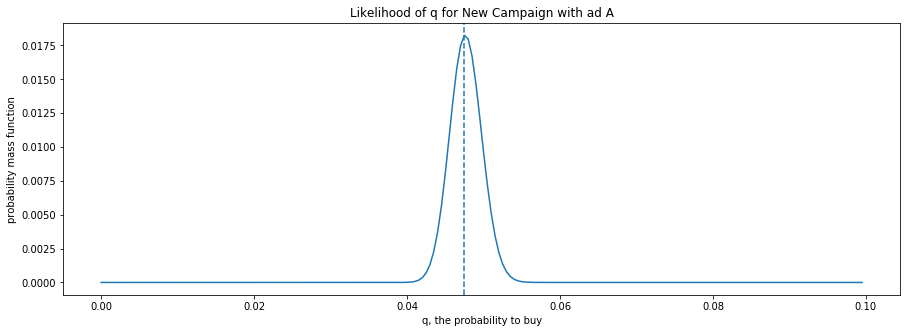

In [12]:
#as we don't know what click through rate best represents the data, we generate a range of possible click through rates
possible_q_values = np.arange(0,0.1,0.0005)

#evaluate the likelihood function for possible click through rates
likelihoods = [likelihood(q,len(A_data),(A_data>0).sum()) for q in possible_q_values]

#pick the best q (i.e. fit the parameter modelling the probability to buy q to our data)
maximum_likelihood_estimation_q = possible_q_values[np.argmax(likelihoods)]

plt.figure(figsize=(15,5))
plt.plot(possible_q_values, likelihoods)
plt.axvline(maximum_likelihood_estimation_q, linestyle = "--")
plt.xlabel("q, the probability to buy")
plt.ylabel("probability mass function")
plt.title("Likelihood of q for New Campaign with ad A")
plt.show()

Unsurprisingly, in this trivial example we see that 0.05 is the most likely value of the probability to buy given 5 customers out of 100 visitors. What's interesting and non-obvious is that we get a sense for the uncertainty around this value: it wouldn't be very surprising for $q$ to be 0.04 or even 0.75 given the evidence in this small sample. However, we see already that it'd be pretty surprising for $q$ to be anything higher than 0.11.

**(2) Conjugate prior**
As we discussed, one way to get a convenient analytical solution for our posterior is to use a conjugate prior distribution to model our prior knowledge. If prior knowledge can be well represented by this prior distribution with a set of chosen parameters (called hyper-parameters in this context), then why not!

As I mentioned before, a convenient list of conjugate priors can be found on Wikipedia. A conjugate prior of the binomial distribution is the beta distribution:

$$Prior: P(q) = {q^{\alpha -1}(1-q)^{\beta -1} \over \mathrm {B} (\alpha ,\beta )}$$

where:
- $q$ represents the primary conversion rate here, i.e. the fraction of visitors becoming customers $b/v$, or click-through-rate, etc
- $\alpha$  and $\beta$  are the hyperparameters chosen to reflect any existing belief or information. $\alpha  = 1$ and $\beta  = 1$ would give a uniform distribution, which is how one can model having no prior information.
- $Β(\alpha , \beta )$ is the Beta function, acting as a normalising constant.

The hyperparameters $\alpha$ and $\beta$ can be chosen to visually represent our belief, it can be fitted to a prior dataset, or it can actually be directly interpreted as pseudo-observations $\alpha-1$ success and $\beta -1$ failures.

In this example, let's imagine that we ran the following previous campaigns for ad A:
- 8 purchases out of 100 visitors (8% conversion rate)
- 120 purchases out of 2000 visitors (6% conversion rate)
- 9 purchases out of 100 visitors (9% conversion rate)
- 50 purchases ouf of 1000 visitors (5% conversion rate)
- 80 purchases out of 2000 visitors (4% conversion rate)

Then we could estimate our prior knowledge, assuming all those cases are representative of today's situation and can be aggregated as one big experiment:
- $\alpha - 1 \approx 8 + 120 + 9 + 50 + 80 = 267$
- $\beta - 1 \approx 92 + 1880 + 91 + 950 + 1920 = 4933$

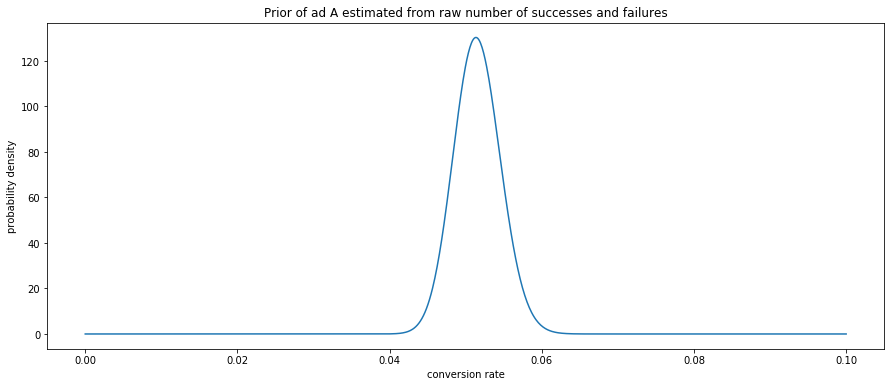

In [13]:
x = np.linspace(0,0.1,1000)
plt.figure(figsize=(15,6))
plt.plot(x,beta.pdf(x, 268, 4934))
plt.xlabel('conversion rate')
plt.ylabel('probability density')
plt.title("Prior of ad A estimated from raw number of successes and failures")
plt.show()

If your colleague only remember previous conversion rate, we can try to fit a beta distribution to these historical conversion rates 8%, 6%, 9%, 5%, 4%

(10.95346736150035, 160.20283473134415, 0, 1)


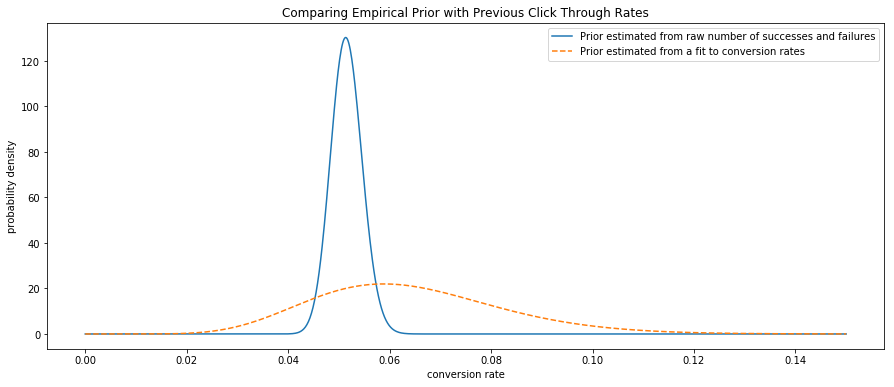

In [14]:
# prior conversion rates
prior_conversion_rates_A = [0.08, 0.06, 0.09, 0.05, 0.04]

# fit beta to previous conversion rates
prior_parameters = beta.fit(prior_conversion_rates_A, floc = 0, fscale = 1)#extract a,b from fit
print(prior_parameters)

prior_a, prior_b = prior_parameters[0:2]

#define prior distribution sample from prior
prior_distribution = beta(prior_a, prior_b)

#plot
x = np.linspace(0,0.15,1000)
plt.figure(figsize=(15,6))
plt.plot(x,beta.pdf(x, 268, 4934), label='Prior estimated from raw number of successes and failures')
plt.plot(x,beta.pdf(x, prior_a, prior_b), label='Prior estimated from a fit to conversion rates', linestyle='--')
plt.legend()
plt.xlabel('conversion rate')
plt.ylabel('probability density')
plt.title("Comparing Empirical Prior with Previous Click Through Rates")
plt.show()

There is a big difference in how the two distributions look, and this is because some campaigns were small and did not provide reliable estimates for the mean conversion rate.

The best is to use raw events, and if one has to use historical conversion rate, at least use only reliable ones.

**Estimating posterior from prior and events of this campaign**
The posterior probability can be calculated using Bayes' theorem: posterior = prior * likelihood / constant. With $q$ the considered click through rate, and with campaign data $b$ the number of customers that bought, $f$ the number of failures ( $f = v - b$ with previous notations):

$$\begin{aligned}Posterior: P(q=x \,| \, b, f) &= \frac{P(q=x) * P(b, f \, | \,q=x)}{P(b,f)} = \frac{P(q=x) * P(b, f \, | \,q=x)}{\int P(q=x) * P(b, f \, | \,q=x) \,dx} \\
&= \frac{\frac{x^{\alpha -1}(1-x)^{\beta -1}}{\mathrm {B}(\alpha ,\beta )} \, *\, {b+f \choose b} \,x^{b}(1-x)^{f}}{\int \frac{y^{\alpha -1}(1-y)^{\beta -1}}{\mathrm {B}(\alpha ,\beta )} \, *\, {b+f \choose b} \,y^{b}(1-y)^{f} dy} \\
&= \frac{x^{\alpha -1}(1-x)^{\beta -1} \, * \,x^{b}(1-x)^{f}}{\int y^{\alpha -1}(1-y)^{\beta -1} \, *\,y^{b}(1-y)^{f} \, dy} \\
&= \frac{x^{\alpha + b -1}(1-x)^{\beta + f -1}}{\int y^{\alpha + b -1}(1-y)^{\beta + f -1} \, dy}
\end{aligned}$$ 

Indeed the binomial coefficient and the beta functions are both independant of y, so they are constant compared to the integration variable and can be simplified. From there, let's remind ourselves that the beta function is originally defined as Euler integral of the first kind (the link with the gamma function is a property):
$$\mathrm{B}(x, y) = \int_{0}^{1} t^{x-1} (1-t)^{y-1} dt$$

So:

$$Posterior: P(q=x \,| \, b, f) = \frac{x^{\alpha + b -1}(1-x)^{\beta + f -1}}{\mathrm{B}(\alpha + b, \beta + f)}$$

which is another Beta distribution with parameters ($\alpha  + b, \beta  + f$). This posterior distribution could then be used as the prior for more samples, with the hyperparameters simply adding each extra piece of information as it comes. This is what we will see in the next (third post) when we look at online learning.

In practice for us:
- the posterior for ad A is a beta function with parameters (268+500, 4934+10000)
- the posterior for ad B is a beta function with parameters (1+600, 1+10000)

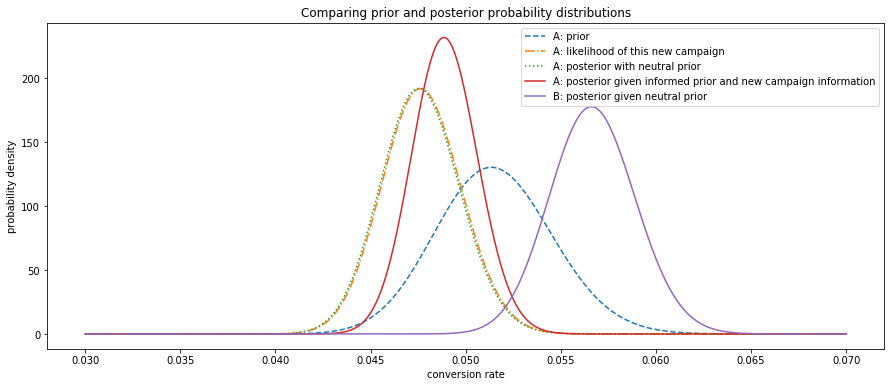

In [15]:
x = np.linspace(0.03,0.07,1000)
bins_width = x[1]-x[0]

plt.figure(figsize=(15,6))
plt.plot(x,beta.pdf(x, 268, 4934), label='A: prior', linestyle = "--")
plt.plot(x, likelihood(x, len(A_data), (A_data>0).sum()) /(sum(likelihood(x, len(A_data), (A_data>0).sum()))*bins_width), label="A: likelihood of this new campaign", linestyle = '-.')
plt.plot(x,beta.pdf(x, (A_data>0).sum(), (A_data==0).sum()), label="A: posterior with neutral prior", linestyle = ':')
plt.plot(x,beta.pdf(x, 268+500, 4934+10000), label='A: posterior given informed prior and new campaign information')
plt.plot(x,beta.pdf(x, 1+600, 1+10000), label='B: posterior given neutral prior')
plt.legend()
plt.xlabel('conversion rate')
plt.ylabel('probability density')
plt.title("Comparing prior and posterior probability distributions")
plt.show()

In the diagram above, one can see a substantial increase in the posterior conversion rate for ad A. Ad A still appears to have a lower conversion rate than ad B, but along with the difference in revenue per customer, the advantage of ad B seems to have decreased.

The next section is about being able to account for prior knowledge in revenue calculations also, as conversion rates only provide part of the picture.

# Capturing prior knowledge - revenue per customer and revenue per visitor

Modelling data with a normal distribution has a convenient normal-inverse gamma distribution conjugate prior. For lognormal data, the log of the data is normally distributed, and the previous method applies.

More details in a future update.